In [14]:

# import libraries
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from os import listdir
import pandas as pd
from pathlib import Path
import plotly.express as px
import seaborn as sns

# create a file named key.py with token = 'your_oanda_token' in the key folder
from key import key

client = API(access_token=key.token)

In [15]:
symbols = ['AUD_CAD', 'AUD_CHF', 'AUD_HKD', 'AUD_JPY', 'AUD_NZD', 'AUD_SGD', 'AUD_USD',
           'CAD_CHF', 'CAD_HKD', 'CAD_JPY', 'CAD_SGD', 'CHF_HKD', 'CHF_JPY', 'EUR_AUD',
           'EUR_CAD', 'EUR_CHF', 'EUR_GBP', 'EUR_HKD', 'EUR_JPY', 'EUR_NZD', 'EUR_SGD',
           'EUR_USD', 'GBP_AUD', 'GBP_CAD', 'GBP_CHF', 'GBP_HKD', 'GBP_JPY', 'GBP_NZD',
           'GBP_SGD', 'GBP_USD', 'HKD_JPY', 'NZD_CAD', 'NZD_CHF', 'NZD_HKD', 'NZD_JPY',
           'NZD_SGD', 'NZD_USD', 'SGD_CHF', 'SGD_HKD', 'SGD_JPY', 'USD_CAD', 'USD_CHF',
           'USD_HKD', 'USD_JPY', 'USD_SGD'] # 45 fx pairs

path = 'db/instruments' # path where to download history data

timeframe = 'D'
lookback = 300


In [23]:
def db(symbols):
    for sym in symbols:
        #print('Downloading '+sym+'...')
        # oanda params
        params = { 'granularity': timeframe,'count': lookback }
        r = instruments.InstrumentsCandles(sym, params)
        r = client.request(r)
        date = r['candles'][0]['time'][0:19]
        ret = 0
        vol = 0
        df = pd.DataFrame({'date': date, 'return': ret,
                          'volatility': vol}, index=[0])
        for i in range(1, len(r['candles'])):
            date = r['candles'][i]['time'][0:19]
            ret = round((float(r['candles'][i]['mid']['c']) /
                         float(r['candles'][i]['mid']['o'])-1)*100, 2)
            vol = round((float(r['candles'][i]['mid']['h']) /
                        float(r['candles'][i]['mid']['l'])-1)*100, 2)
            add = pd.DataFrame(
                {'date': date, 'return': ret, 'volatility': vol}, index=[0])
            df = pd.concat([df, add], ignore_index=True)

        Path(path+'/'+timeframe).mkdir(parents=True, exist_ok=True)
        df.to_csv(path+'/'+timeframe+'/'+sym+'.csv', index=False)

db(symbols)
#print('db: '+timeframe+' history updated!')

In [21]:
def index(currency, timeframe):
    files = [k for k in listdir('db/instruments/'+timeframe) if currency in k]
    df = pd.read_csv('db/instruments/'+timeframe+'/'+files[0])
    if files[0][0:3] != currency:
        df['return'] = -df['return']
    df = df.rename(columns={'return': files[0][0:7]})
    for i in range(1, len(files)):
        df2 = pd.read_csv('db/instruments/'+timeframe+'/'+files[i])
        if files[i][0:3] != currency:
            df2['return'] = -df2['return']
        df2 = df2.rename(columns={'return': files[i][0:7]})
        df = pd.merge(df, df2, on=['date', 'date'])
    df = df.fillna(0)
    df = df.set_index('date')
    df[currency] = round(df.sum(axis=1)/len(currencies), 2)
    df = df[currency]
    Path('db/indexes/raw/'+timeframe).mkdir(parents=True, exist_ok=True)
    df.to_csv('db/indexes/raw/'+timeframe+'/'+currency+'.csv', index=True)
    #print(timeframe, currency, 'done')

currencies = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'HKD', 'JPY', 'NZD', 'SGD', 'USD']

for curr in currencies:
        index(curr, timeframe)

[Text(0.5, 1.0, 'FX G10 Correlation Matrix\n')]

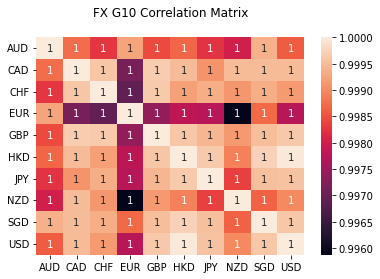

In [20]:
df = pd.read_csv('db/indexes/raw/'+timeframe+'/'+currencies[0]+'.csv')
df[currencies[0]] = df[currencies[0]].cumsum()

for i in range(1, len(currencies)):
    df2 = pd.read_csv('db/indexes/raw/'+timeframe+'/'+currencies[i]+'.csv')
    df2[currencies[i]] = df2[currencies[i]].cumsum()
    df = pd.merge(df, df2, on=['date', 'date'])

pd.options.plotting.backend = "plotly"
plt = df.plot(x='date', y=currencies)
plt.show()

matrix = df.corr()
hm = sns.heatmap(matrix, annot=True)
hm.set(title="FX G10 Correlation Matrix\n")
